In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pysal
from libpysal import cg
import seaborn as sns
import contextily
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pointpats import centrography
from matplotlib.patches import Ellipse
from shapely.geometry import shape, Polygon, MultiPolygon
from descartes import PolygonPatch
from sklearn.cluster import DBSCAN

## Leer Datos


In [3]:
db = pd.read_csv('./data/hurto_a_residencia.csv')

In [4]:
db.head()

fecha_hecho  cantidad   latitud   longitud    sexo  edad  \
0  2017-01-01T13:51:00.000-05:00       1.0  6.251238 -75.586712   Mujer    38   
1  2017-01-01T13:51:00.000-05:00       1.0  6.251238 -75.586712   Mujer    38   
2  2017-01-01T13:51:00.000-05:00       1.0  6.251238 -75.586712   Mujer    38   
3  2017-01-01T00:00:00.000-05:00       1.0  6.262758 -75.593850  Hombre    62   
4  2017-01-01T00:00:00.000-05:00       1.0  6.280006 -75.564721   Mujer    53   

  estado_civil grupo_actor actividad_delictiva parentesco  ...  \
0    Casado(a)    Sin dato            Sin dato   Sin dato  ...   
1    Casado(a)    Sin dato            Sin dato   Sin dato  ...   
2    Casado(a)    Sin dato            Sin dato   Sin dato  ...   
3   Soltero(a)    Sin dato            Sin dato   Sin dato  ...   
4   Soltero(a)    Sin dato            Sin dato   Sin dato  ...   

                   lugar sede_receptora  \
0  Hotel, motel y hostal       Laureles   
1  Hotel, motel y hostal       Laureles   
2  Hotel, motel y hostal       Laureles   
3  Hotel, motel y hostal       Laureles   
4  Hotel, motel y hostal       Aranjuez   

                                          bien  \
0                 Accesorios prendas de vestir   
1  Electrodoméstico video y audio y accesorios   
2                                      Celular   
3                                    Bicicleta   
4                                         Peso   

                                    categoria_bien grupo_bien modelo  \
0                   Prendas de vestir y accesorios  Mercancía     -1   
1                                Electrodomésticos  Mercancía     -1   
2                                       Tecnología  Mercancía     -1   
3                        Vehículos de 2 o 4 ruedas   Vehículo     -1   
4  Dinero, joyas, piedras preciosas y título valor  Mercancía     -1   

      color   permiso unidad_medida                fecha_ingestion  
0       Oro  Sin dato      Sin dato  2025-03-06T04:05:02.000-05:00  
1     Negro  Sin dato      Sin dato  2025-03-06T04:05:02.000-05:00  
2     Negro  Sin dato      Sin dato  2025-03-06T04:05:02.000-05:00  
3  Sin dato  Sin dato      Sin dato  2025-03-06T04:05:02.000-05:00  
4  Sin dato  Sin dato      Sin dato  2025-03-06T04:05:02.000-05:00  

[5 rows x 36 columns]

In [5]:
db.keys()

Index(['fecha_hecho', 'cantidad', 'latitud', 'longitud', 'sexo', 'edad',
       'estado_civil', 'grupo_actor', 'actividad_delictiva', 'parentesco',
       'ocupacion', 'discapacidad', 'grupo_especial', 'medio_transporte',
       'nivel_academico', 'testigo', 'conducta', 'modalidad',
       'caracterizacion', 'conducta_especial', 'arma_medio', 'articulo_penal',
       'categoria_penal', 'nombre_barrio', 'codigo_barrio', 'codigo_comuna',
       'lugar', 'sede_receptora', 'bien', 'categoria_bien', 'grupo_bien',
       'modelo', 'color', 'permiso', 'unidad_medida', 'fecha_ingestion'],
      dtype='object')

## Exploración

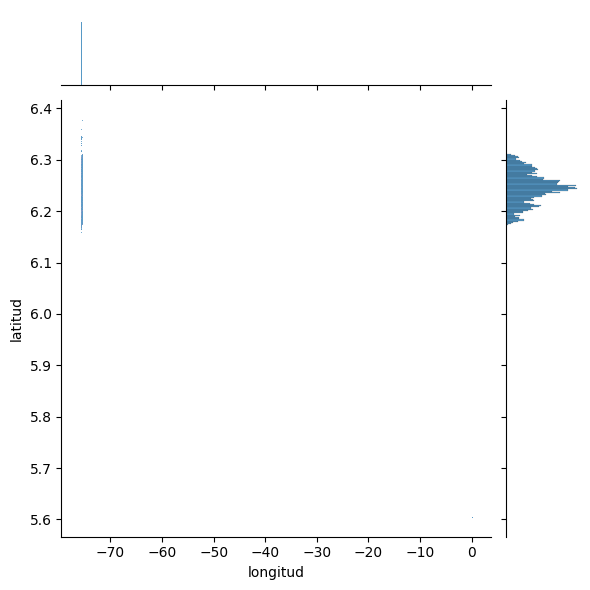

In [6]:
# Generate scatter plot
sns.jointplot(x="longitud", y="latitud", data=db, s=0.5)

In [7]:
db[['longitud', 'latitud']].describe()

longitud       latitud
count  38343.000000  38343.000000
mean     -75.571624      6.245523
std        0.863400      0.031136
min      -75.709227      5.605000
25%      -75.599618      6.226033
50%      -75.583442      6.246407
75%      -75.561705      6.265323
max       -0.000679      6.377163

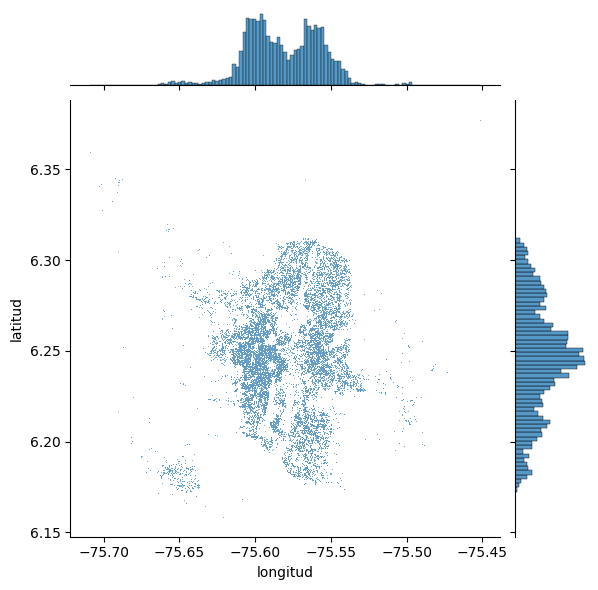

In [8]:
# Generate scatter plot
sns.jointplot(x="longitud", y="latitud", data=db[db['longitud']<-50], s=0.5)

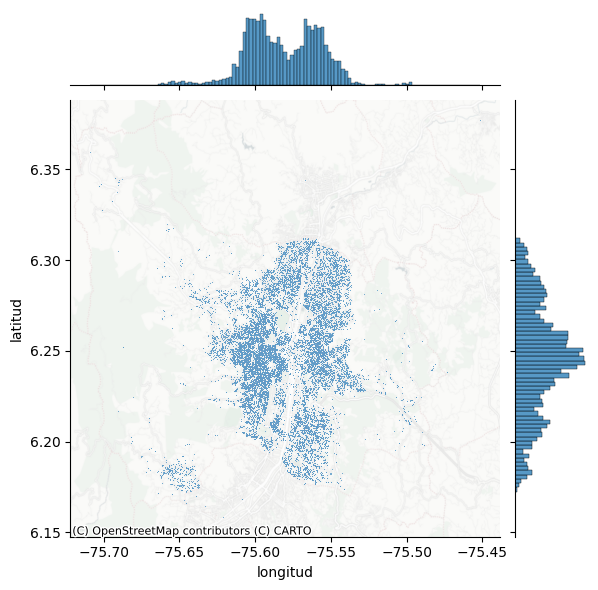

In [9]:
# Generate scatter plot
joint_axes = sns.jointplot(
    x="longitud", y="latitud", data=db[db['longitud']<-50], s=0.5
)
contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
)

In [10]:
db=db[db['longitud']<-50].copy()

## Visualización de la densidad con hexbinning

Aquí, generamos una cuadrícula regular (ya sea cuadrada o hexagonal), contamos cuántos puntos caen dentro de cada celda y la presentamos como cualquier otro mapa coroplético. Si la cuadrícula regular es lo suficientemente fina, elimina algunas de las distorsiones de área que pueden inducir los mapas coropléticos.

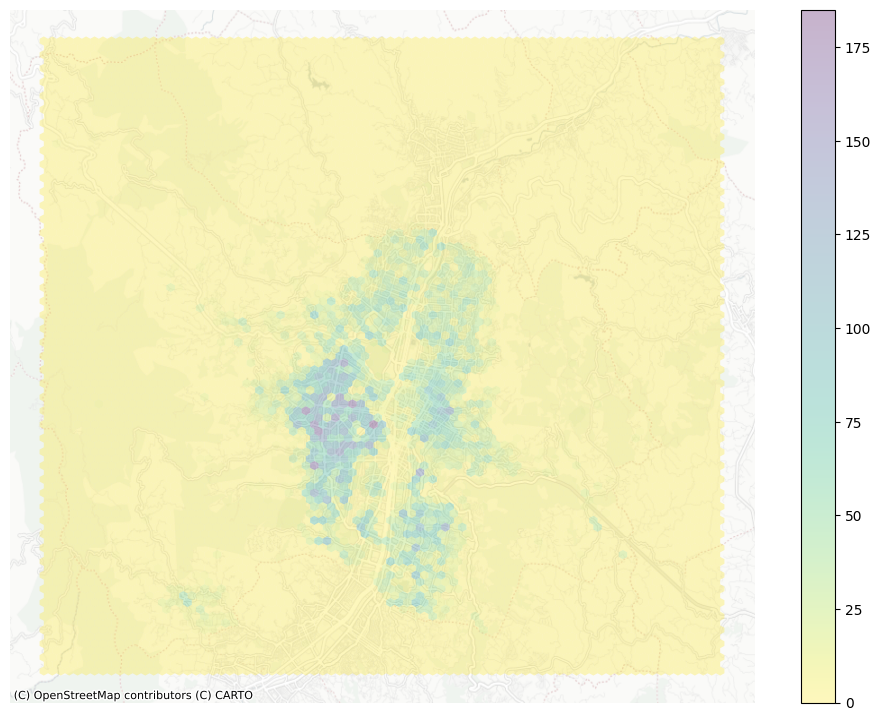

In [11]:
# Convertir a GeoDataFrame y reproyectar
gdf = gpd.GeoDataFrame(
    db,
    geometry=gpd.points_from_xy(db["longitud"], db["latitud"]),
    crs="EPSG:4326"
).to_crs(epsg=3857) ## Los mapas base de contextily usan EPSG:3857

# Crear figura
f, ax = plt.subplots(1, figsize=(12, 9))

# Hexbin
hb = ax.hexbin(
    gdf.geometry.x,
    gdf.geometry.y,
    gridsize=80, # Divide el ancho total del mapa (mín_x → máx_x) en 80 columnas de hexágonos 
    linewidths=0,
    alpha=0.3,
    cmap="viridis_r",
)

# Basemap en el mismo axis
contextily.add_basemap(
    ax,
    crs=gdf.crs.to_string(),
    source=contextily.providers.CartoDB.PositronNoLabels,
)

# Colorbar
plt.colorbar(hb, ax=ax)

# Quitar ejes
ax.set_axis_off()

plt.show()

## Estimación de densidad kernel
Un KDE 2D genera una “superficie” de densidad, y Seaborn la representa visualmente mediante contornos y rellenos tipo isodensidad (Línea o superficie que conecta puntos con la MISMA densidad).

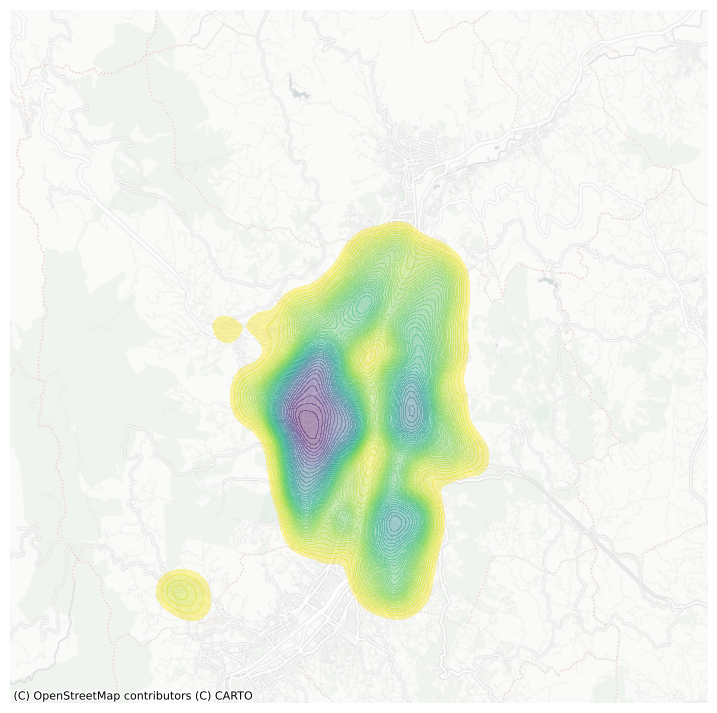

In [12]:
# Convertir a GeoDataFrame y reproyectar
gdf = gpd.GeoDataFrame(
    db,
    geometry=gpd.points_from_xy(db["longitud"], db["latitud"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# Estimación de densidad kernel
f, ax = plt.subplots(1, figsize=(9, 9))
sns.kdeplot(
    x=gdf.geometry.x,
    y=gdf.geometry.y,
    data=db,
    n_levels=50, # Define cuántas curvas de nivel de densidad 
    fill=True,
    alpha=0.4,
    cmap="viridis_r",
)
# Add basemap
# Basemap en el mismo axis
contextily.add_basemap(
    ax,
    crs=gdf.crs.to_string(),
    source=contextily.providers.CartoDB.PositronNoLabels,
)
# Remove axes
ax.set_axis_off()

## Centrografía
La centrografía es el análisis de la centralidad en un patrón de puntos. Por "centralidad" entendemos la ubicación general y la dispersión del patrón.

### Tendencia 
Una medida común de tendencia central para un patrón de puntos es su centro de masa. Para patrones de puntos marcados, el centro de masa identifica un punto central cercano a las observaciones con valores más altos en el atributo marcado. Para patrones de puntos no marcados, el centro de masa equivale al centro medio, o promedio de los valores de las coordenadas.

In [13]:
mean_center = centrography.mean_center(db[["longitud", "latitud"]])
med_center = centrography.euclidean_median(db[["longitud", "latitud"]])

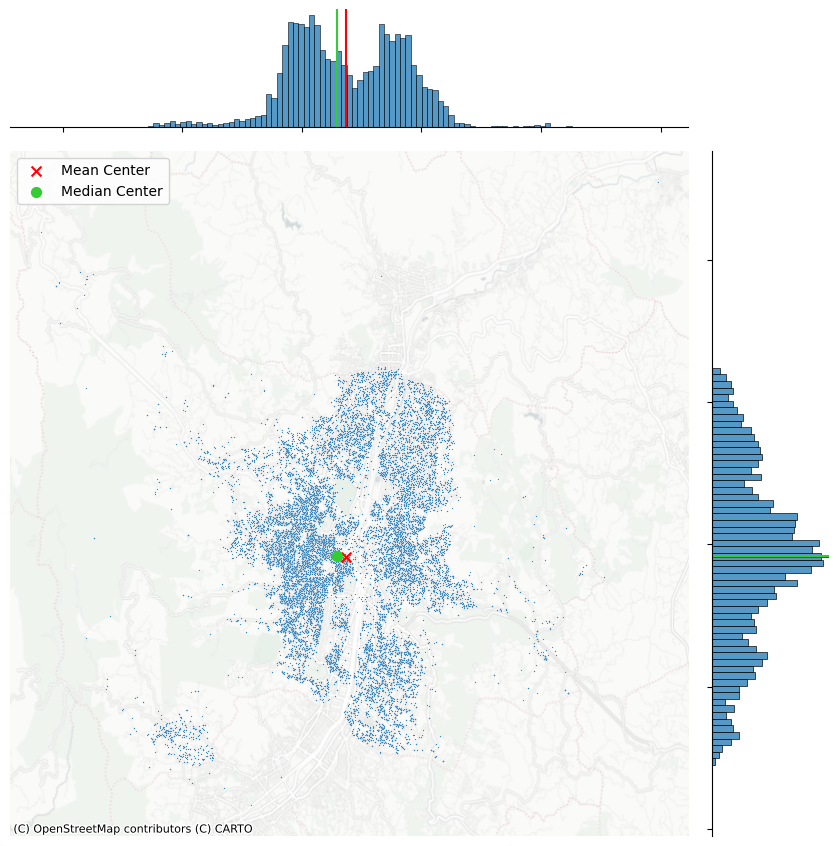

In [14]:
# Generate scatterplot
joint_axes = sns.jointplot(
    x="longitud", y="latitud", data=db, s=0.75, height=9
)
# Add mean point and marginal lines
joint_axes.ax_joint.scatter(
    *mean_center, color="red", marker="x", s=50, label="Mean Center"
)
joint_axes.ax_marg_x.axvline(mean_center[0], color="red")
joint_axes.ax_marg_y.axhline(mean_center[1], color="red")
# Add median point and marginal lines
joint_axes.ax_joint.scatter(
    *med_center,
    color="limegreen",
    marker="o",
    s=50,
    label="Median Center"
)
joint_axes.ax_marg_x.axvline(med_center[0], color="limegreen")
joint_axes.ax_marg_y.axhline(med_center[1], color="limegreen")
# Legend
joint_axes.ax_joint.legend()
# Add basemap
contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
)
# Clean axes
joint_axes.ax_joint.set_axis_off()
# Display
plt.show()

### Dispersión
Una medida de dispersión común en centrografía es la distancia estándar . Esta medida proporciona la distancia promedio al centro de la nube de puntos (medida, por ejemplo, por el centro de masa).

In [15]:
# Dispersión estandar en grados
centrography.std_distance(db[["longitud", "latitud"]])

0.039215422077184384

In [16]:
# teniendo en cuenta que 1 grado es aproximadamente 101 km
centrography.std_distance(db[["longitud", "latitud"]]) * 101


3.960757629795623

### Elipse de desviación estándar
Resume la forma, orientación y dispersión de un conjunto de puntos en dos dimensiones. Se define mediante tres parámetros:

- **Semieje mayor (major):** desviación estándar máxima, asociada a la 
  dirección de mayor dispersión. Se obtiene como la raíz cuadrada del 
  mayor autovalor de la matriz de covarianza.

- **Semieje menor (minor):** desviación estándar mínima, perpendicular 
  al eje mayor. Es la raíz del menor autovalor.

- **Rotación (θ):** orientación del eje mayor, calculada a partir del 
  autovector principal como θ = $arctan2(v_y, v_x)$.

El centro de la elipse coincide con el centro medio del conjunto. La SDE 
permite identificar dirección dominante, dispersión espacial y forma del 
fenómeno analizado. 

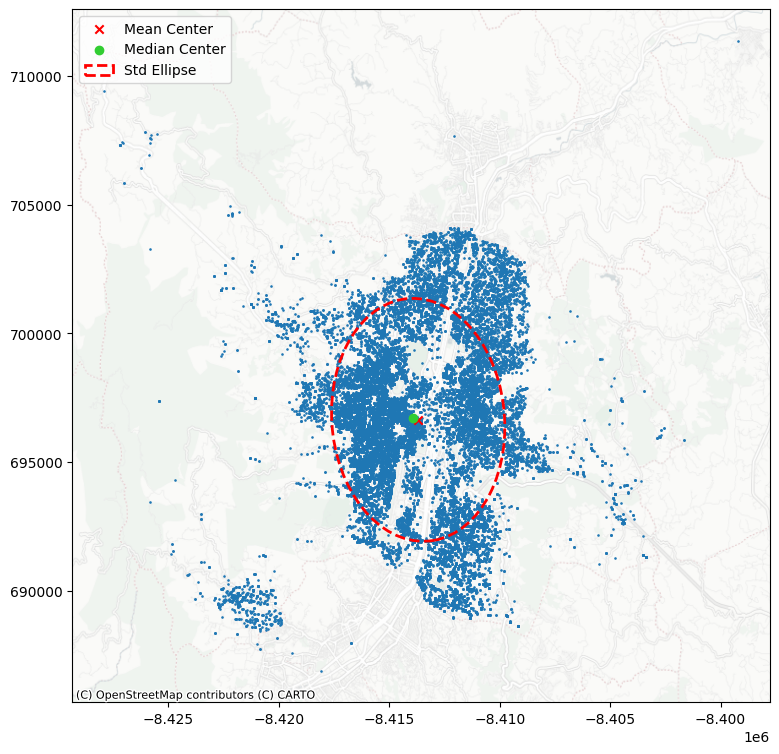

In [17]:
# 1. Crear GeoDataFrame y reproyectar
gdf = gpd.GeoDataFrame(
    db,
    geometry=gpd.points_from_xy(db["longitud"], db["latitud"]),
    crs="EPSG:4326"
).to_crs(3857)

# Extraer coordenadas en 3857
gdf["x"] = gdf.geometry.x
gdf["y"] = gdf.geometry.y

# 2. Recalcular mean y median center en metros
mean_center = (gdf["x"].mean(), gdf["y"].mean())
med_center  = (gdf["x"].median(), gdf["y"].median())

# 3. Elipse de desviación estándar EN 3857
major, minor, rotation = centrography.ellipse(gdf[["x", "y"]])

# 4. Graficar
fig, ax = plt.subplots(figsize=(9,9))

ax.scatter(gdf["x"], gdf["y"], s=0.75)
ax.scatter(*mean_center, color="red", marker="x", label="Mean Center")
ax.scatter(*med_center, color="limegreen", marker="o", label="Median Center")

# Construir elipse correctamente proyectada
ellipse = Ellipse(
    xy=mean_center,
    width=major * 2,
    height=minor * 2,
    angle=np.degrees(rotation),
    facecolor="none",
    edgecolor="red",
    linestyle="--",
    linewidth=2,
    label="Std Ellipse"
)

ax.add_patch(ellipse)
ax.legend()

# 5. Basemap correcto
contextily.add_basemap(
    ax,
    crs="EPSG:3857",
    source=contextily.providers.CartoDB.PositronNoLabels
)

plt.show()

### Envolvente convexa y Alpha Shape

- La envolvente convexa es el polígono convexo más pequeño que contiene a todos los puntos de un conjunto. 
- El Alpha Shape es una generalización del Convex Hull que permite obtener un contorno cóncavo, capaz de capturar la forma real del conjunto de puntos. Utiliza un parámetro α para controlar la curvatura del borde.
- Los círculos alpha son los círculos vacíos utilizados para determinar el contorno del Alpha Shape. Un círculo alpha es un círculo de radio ≤ α que toca dos o tres puntos del conjunto sin contener otros puntos en su interior.

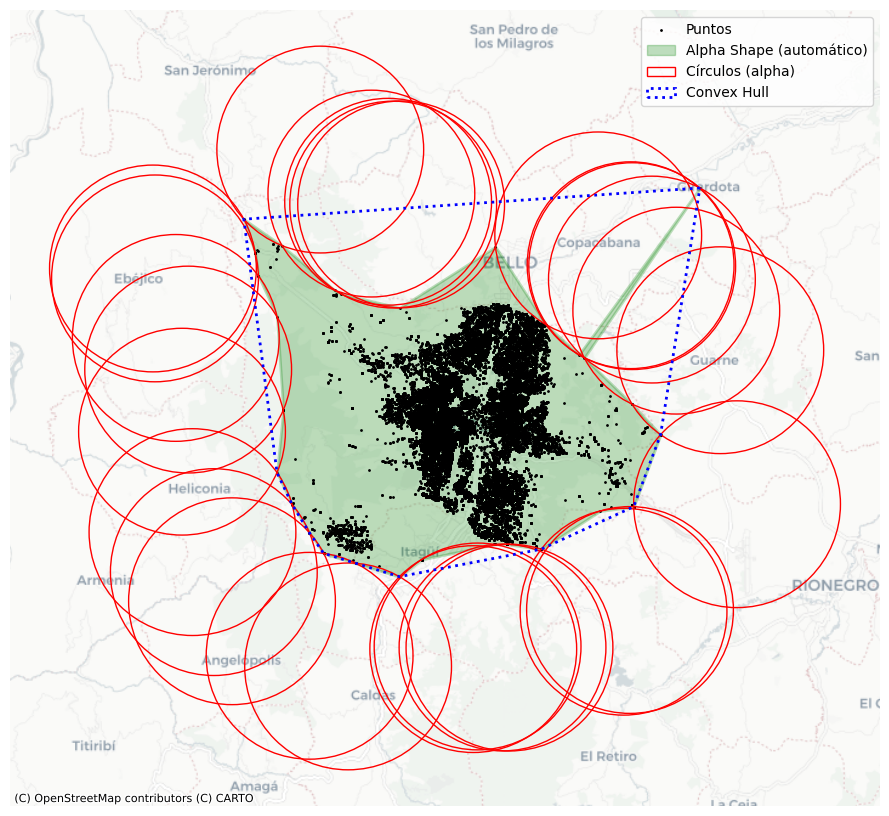

In [18]:
# ==============================
# 1. Convertir a GeoDataFrame y reproyectar
# ==============================
gdf = gpd.GeoDataFrame(
    db,
    geometry=gpd.points_from_xy(db["longitud"], db["latitud"]),
    crs="EPSG:4326"
).to_crs(3857)

# Extraer coordenadas (Nx2)
coordinates = np.column_stack([gdf.geometry.x, gdf.geometry.y])

# ==============================
# 2. Envolvente convexa
# ==============================
convex_hull_vertices = centrography.hull(coordinates)

#  Conversión a un poligono
convex_hull_polygon = Polygon(convex_hull_vertices)

# ==============================
# 3. Alpha Shape (automático)
# ==============================
alpha_shape, alpha, circs = cg.alpha_shape_auto(
    coordinates, return_circles=True
)

# ==============================
# 4. Graficar todo
# ==============================
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

# --- 4.1 Alpha Shape (verde) ---
gpd.GeoSeries([alpha_shape]).plot(
    ax=ax,
    edgecolor="green",
    facecolor="green",
    alpha=0.25,
    linewidth=2
)

# proxy artist para la leyenda
alpha_proxy = patches.Patch(
    facecolor="green",
    edgecolor="green",
    alpha=0.25,
    label="Alpha Shape (automático)"
)

# --- 4.2 Puntos originales ---
points_plot = ax.scatter(
    coordinates[:, 0], coordinates[:, 1],
    color="black", s=1,
    label="Puntos"
)

# --- 4.3 Círculos generadores (rojos) ---
circle_handles = []
for i, circle in enumerate(circs):
    h = plt.Circle(
        circle, radius=alpha,
        facecolor="none",
        edgecolor="red",
        linewidth=1
    )
    ax.add_patch(h)
    if i == 0:  # solo añadimos uno a la leyenda
        circle_handles.append(
            patches.Patch(facecolor="none", edgecolor="red", label="Círculos (alpha)")
        )

# --- 4.4 Convex Hull (azul punteado) ---
hull_patch = patches.Polygon(
    convex_hull_vertices,
    closed=True,
    edgecolor="blue",
    facecolor="none",
    linestyle=":",
    linewidth=2,
    label="Convex Hull"
)
ax.add_patch(hull_patch)

# ==============================
# 5. Basemap
# ==============================
contextily.add_basemap(
    ax,
    crs="EPSG:3857",
    source=contextily.providers.CartoDB.Positron
)

# ==============================
# 6. LEYENDA (con todos los proxies)
# ==============================
handles = [
    points_plot,
    alpha_proxy,
    circle_handles[0],
    hull_patch,
]

ax.legend(handles=handles, loc="upper right")

# ==============================
# 7. Ajustes finales
# ==============================
ax.set_axis_off()
plt.tight_layout()
plt.show()

## Aleatoriedad y agrupamiento

La estadística espacial sobre patrones de puntos suele analizar la uniformidad de la distribución de puntos. Con esto, nos referimos a si los puntos tienden a agruparse cerca unos de otros o a dispersarse uniformemente por toda el área del problema.

### Puntos de Poisson
Puntos generados aleatoriamente, como se veria? (como es un proceso totalmente aleatirio no hay agrupamiento ni dispersión)

In [19]:
from pointpats import (
    distance_statistics,
    QStatistic,
    random,
    PointPattern,
)

In [20]:
# EL 100% del numero de puntos originales es dividido por este numero
divisor = 8
resize=int(len(coordinates)/divisor)

In [21]:
random_pattern = random.poisson(coordinates, size=resize)

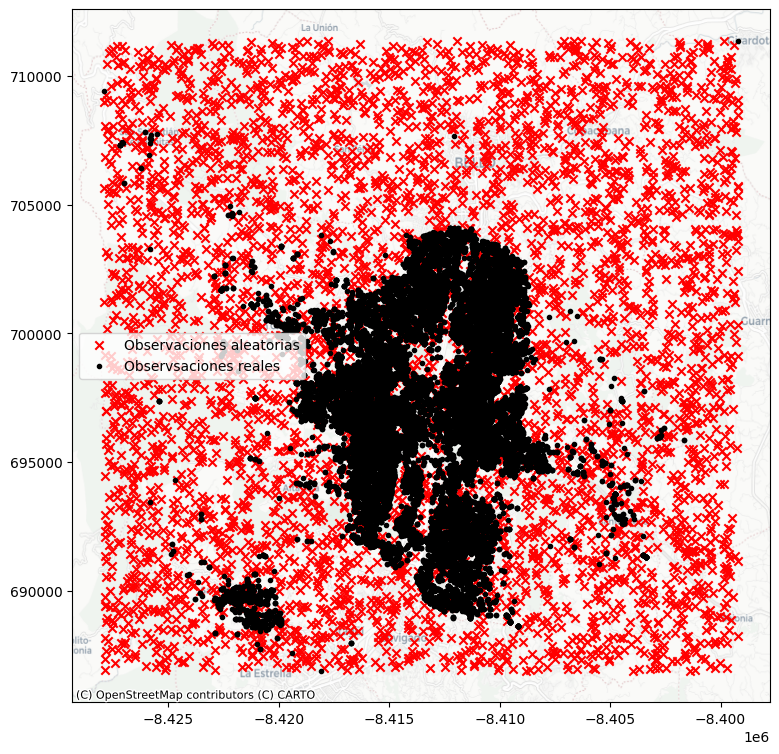

In [22]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.scatter(*random_pattern.T, color="r", marker="x", label="Observaciones aleatorias")
plt.scatter(
    *coordinates.T,
    color="k",
    marker=".",
    label="Observsaciones reales"
)
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
ax.legend(ncol=1, loc="center left")
plt.show()

In [23]:
# Patron aleatorio basado en alpha shape
random_pattern_ashape = random.poisson(
    alpha_shape, size=resize
)

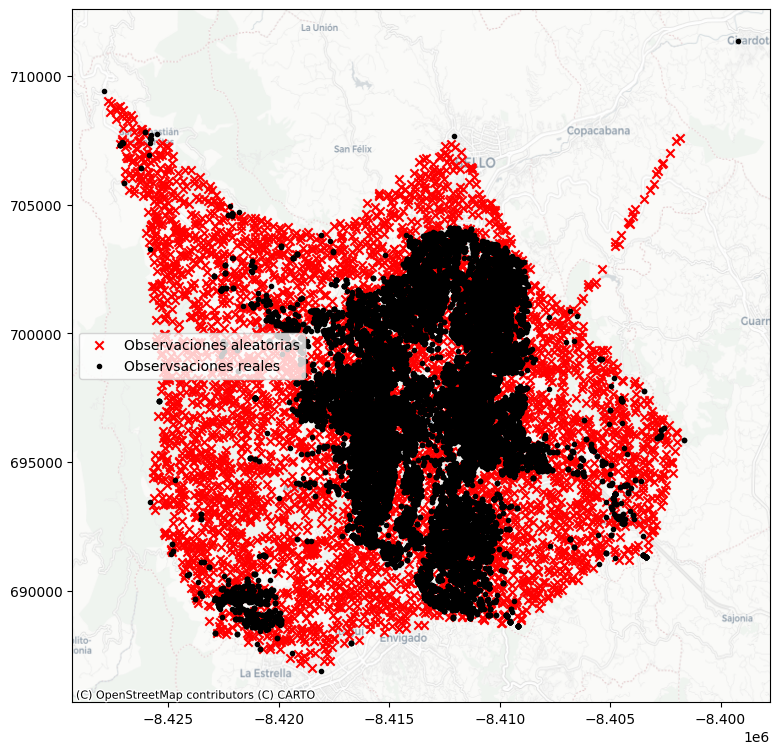

In [24]:
f, ax = plt.subplots(1, figsize=(9, 9))
plt.scatter(
    *random_pattern_ashape.T, color="r", marker="x", label="Observaciones aleatorias"
)
plt.scatter(*coordinates.T, color="k", marker=".", label="Observsaciones reales")

contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
ax.legend(ncol=1, loc="center left")
plt.show()

### Estadísticas de cuadrantes
La estadística de cuadrantes examina la distribución espacial de los puntos en un área en términos del número de observaciones que caen dentro de una celda dada. Al examinar si las observaciones se distribuyen uniformemente entre las celdas, el enfoque de cuadrantes busca estimar si los puntos están dispersos o agrupados en unas pocas celdas. En sentido estricto, la estadística de cuadrantes examina la uniformidad de la distribución entre las celdas mediante la prueba estadística $ \chi^2 $ (prueba estadística para determinar si hay una asociación significativa entre  variables categóricas/cualitativas. En este caso la hipotesis nula es que las celdas no son diferentes, es decir, existe una distribución uniforme de las observaciones).

¿La intensidad de puntos es constante en todos los cuadrantes, como se espera bajo un proceso espacial completamente aleatorio (CSR)?

Si se rechaza la hipotesis nula: hay evidencia de agregación (clustering) o dispersión. 

Estamos evaluando si las frecuencias observadas por cuadrante coinciden con las frecuencias esperadas bajo una probabilidad uniforme proporcional al área.

<Axes: title={'center': 'Quadrat Count'}>

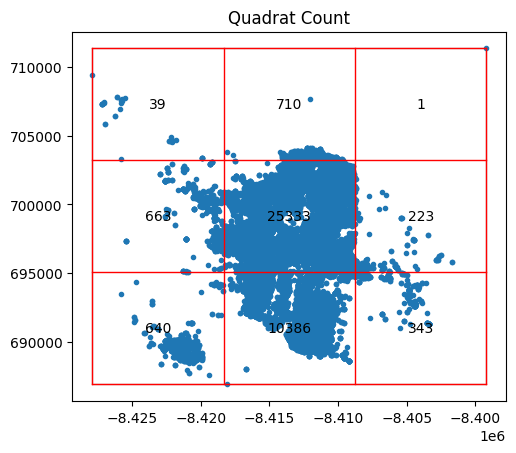

In [25]:
qstat = QStatistic(coordinates)
qstat.plot()

In [26]:
qstat.chi2_pvalue

0.0

<Axes: title={'center': 'Quadrat Count'}>

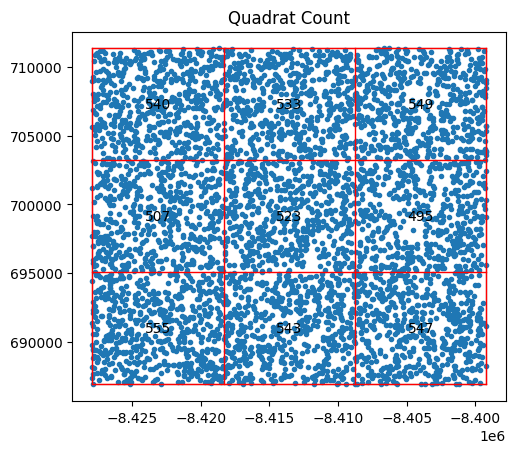

In [27]:
qstat_null = QStatistic(random_pattern)
qstat_null.plot()

In [28]:
# Estadistico para un patrón aleatorio (no se rechaza la hipótesis nula)
qstat_null.chi2_pvalue
# La distribución de puntos entre cuadrantes no difiere significativamente de la que tendría un proceso espacial completamente aleatorio


0.6246158988153372

<Axes: title={'center': 'Quadrat Count'}>

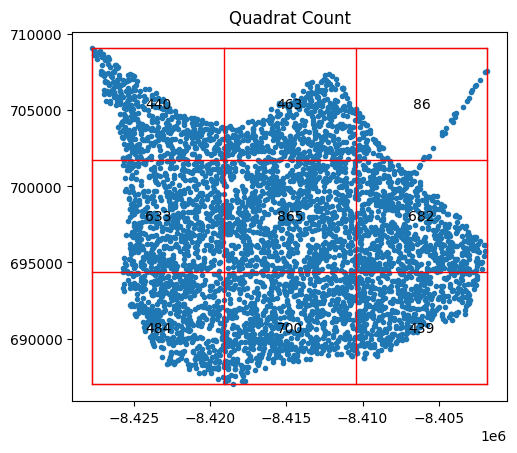

In [29]:
qstat_null_ashape = QStatistic(random_pattern_ashape)
qstat_null_ashape.plot()

In [30]:
qstat_null_ashape.chi2_pvalue

7.551223741407274e-155

Los conteos de cuadrantes pueden presentar problemas con áreas de estudio irregulares, por lo que se debe tener cuidado para evitar la identificación errónea de agrupamientos. Una forma de interpretar la estadística de cuadrantes que concilia casos como el mencionado es considerarla como una prueba que considera tanto la uniformidad de los puntos como la forma de su extensión para examinar si el patrón resultante es uniforme en una cuadrícula regular. En algunos casos, esta herramienta es útil; en otros, debe utilizarse con precaución.

### El Alfabeto de Ripley

A diferencia de las estadísticas de cuadrantes, que dividen el espacio en celdas arbitrarias, las funciones de Ripley analizan la estructura espacial basándose en las distancias entre observaciones. Su gran ventaja es que no resumen el patrón en un solo número, sino que describen cómo cambia el comportamiento del patrón (agrupado, disperso o aleatorio) a medida que aumentamos la escala de análisis (el radio de distancia $d$).Se les llama "alfabeto" porque utilizan letras mayúsculas ($G$, $F$, $K$, $L$) para denotar distintas formas de medir estas relaciones espaciales.

#### Perspectiva "Evento-a-Evento": Función $G$
Esta función analiza la "intimidad" entre los puntos existentes. Se hace la pregunta: "Dado un punto de mis datos, ¿qué tan cerca está el siguiente punto de datos?".
- Nombre técnico: Función de Distancia al Vecino Más Cercano (Nearest Neighbor Distance Function).
- Concepto: Calcula la distribución acumulada de las distancias desde cada evento observado hasta su vecino más próximo $d_{min}$. El algoritmo toma cada uno de tus puntos observados y para cada uno busca cuál es su vecino más cercano.
- Interpretación:
  - Si $G(d)$ crece rápidamente a distancias cortas, indica que los puntos tienen vecinos muy cerca $\rightarrow$ Agrupamiento (Clustering).
  - Si crece lentamente, los puntos están aislados $\rightarrow$ Dispersión.

In [31]:
g_test = distance_statistics.g_test(
    coordinates, 
    support=100,          
    keep_simulations=True,
    hull=convex_hull_polygon, # alpha_shape,
     n_simulations=200      # Por defecto es 999 - demasiadas simulaciones
)

La distribución de estos porcentajes acumulados presenta una forma distintiva en procesos completamente aleatorios en el espacio. La intuición detrás de la G de Ripley es la siguiente: podemos determinar la similitud de nuestro patrón con uno aleatorio en el espacio calculando la distribución acumulada de las distancias del vecino más cercano sobre umbrales de distancia crecientes y comparándola con la de un conjunto de patrones simulados que siguen un proceso aleatorio en el espacio conocido. Generalmente, se utiliza un proceso de puntos de Poisson espacial como distribución de referencia.



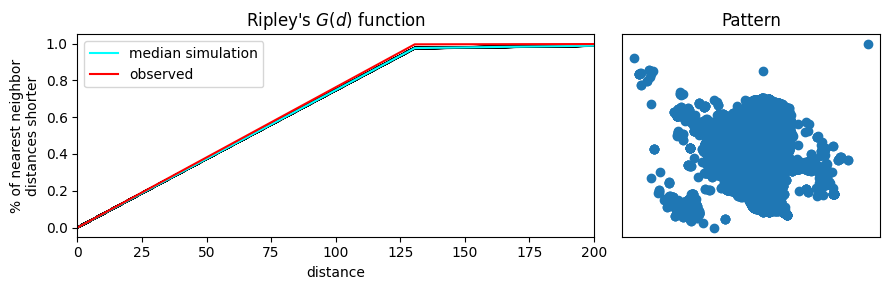

In [32]:
f, ax = plt.subplots(
    1, 2, figsize=(9, 3), gridspec_kw=dict(width_ratios=(6, 3))
)
# plot all the simulations with very fine lines
ax[0].plot(
    g_test.support, g_test.simulations.T, color="k"
)
# and show the average of simulations
ax[0].plot(
    g_test.support,
    np.median(g_test.simulations, axis=0),
    color="cyan",
    label="median simulation",
)


# and the observed pattern's G function
ax[0].plot(
    g_test.support, g_test.statistic, label="observed", color="red"
)

# clean up labels and axes
ax[0].set_xlabel("distance")
ax[0].set_ylabel("% of nearest neighbor\ndistances shorter")
ax[0].legend()
ax[0].set_xlim(0, 200)
ax[0].set_title(r"Ripley's $G(d)$ function")

# plot the pattern itself on the next frame
ax[1].scatter(*coordinates.T)

# and clean up labels and axes there, too
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_title("Pattern")
f.tight_layout()
plt.show()

Considerando estas distribuciones de distancias, un patrón "agrupado" debe tener más puntos cercanos que un patrón "disperso"; y un patrón completamente aleatorio debe tener algo intermedio. Por lo tanto, si la función $G$ aumenta rápidamente con la distancia, probablemente tengamos un patrón agrupado. Si aumenta lentamente con la distancia, tendremos un patrón disperso. Un punto intermedio será difícil de distinguir del azar puro.

#### Perspectiva "Punto-a-Evento": Función $F$
Esta función analiza el "vacío" o el espacio libre en el mapa. Se hace la pregunta: "Si caigo en cualquier lugar aleatorio del mapa, ¿qué tan lejos tengo que viajar para encontrar un dato?".
- Nombre técnico: Función de Espacio Vacío (Empty Space Function).
- Concepto: Selecciona puntos aleatorios en el área de estudio (donde no necesariamente hay eventos) y mide la distancia al evento observado más cercano. El algoritmo genera nuevos puntos artificiales (una rejilla regular o puntos aleatorios) que representan el "espacio vacío" (no necesariamente tiene en cuenta todos los puntos del dataset).
- Interpretación:
  - Si $F(d)$ crece lentamente, significa que hay grandes huecos vacíos donde puedes caer y estar lejos de todo $\rightarrow$ Agrupamiento (los datos están todos en una esquina, dejando el resto vacío).
  - Si crece rápidamente, el espacio está bien "cubierto" $\rightarrow$ Dispersión/Regularidad.

In [33]:
f_test = distance_statistics.f_test(
    coordinates, 
    support=100,          
    keep_simulations=True,
    hull=alpha_shape, # Si no se usa un hull, toma el bounding box
    n_simulations=150      # Por defecto es 999 - demasiadas simulaciones
)

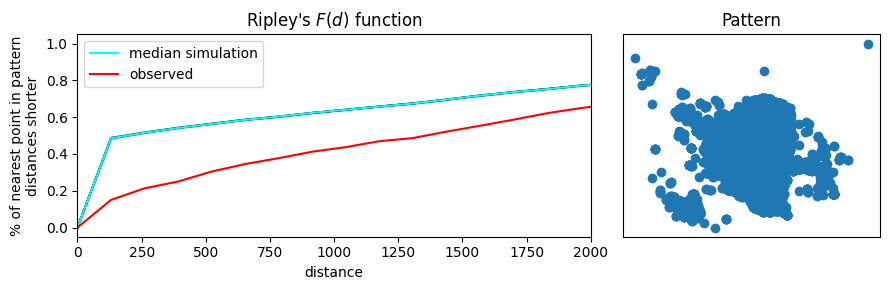

In [34]:
f, ax = plt.subplots(
    1, 2, figsize=(9, 3), gridspec_kw=dict(width_ratios=(6, 3))
)

# plot all the simulations with very fine lines
ax[0].plot(
    f_test.support, f_test.simulations.T, color="k", alpha=0.01
)
# and show the average of simulations
ax[0].plot(
    f_test.support,
    np.median(f_test.simulations, axis=0),
    color="cyan",
    label="median simulation",
)


# and the observed pattern's F function
ax[0].plot(
    f_test.support, f_test.statistic, label="observed", color="red"
)

# clean up labels and axes
ax[0].set_xlabel("distance")
ax[0].set_ylabel("% of nearest point in pattern\ndistances shorter")
ax[0].legend()
ax[0].set_xlim(0, 2000)
ax[0].set_title(r"Ripley's $F(d)$ function")

# plot the pattern itself on the next frame
ax[1].scatter(*coordinates.T)

# and clean up labels and axes there, too
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_title("Pattern")
f.tight_layout() 
plt.show()

#### La perspectiva global: Función $K$ (y $L$)
Mientras que $G$ solo mira al vecino más cercano, la función $K$ es más ambiciosa: mira todos los vecinos dentro de un radio.
- Nombre técnico: Función $K$ de Ripley.
- Concepto: Cuenta el número promedio de eventos extra que se encuentran dentro de una distancia $d$ de un evento cualquiera. El algoritmo visita cada punto del dataset y traza círculos de radio $d$ alrededor de él. Cuenta cuántos otros puntos caen dentro.
- El problema de visualización: Como el área de un círculo crece exponencialmente ($\pi r^2$), la gráfica de $K$ siempre se curva hacia arriba, lo que hace difícil ver desviaciones sutiles.
- La solución (Función $L$): Es simplemente una transformación matemática de $K$ para "aplanarla".
  $$L(d) = \sqrt{\frac{K(d)}{\pi}} - d$$
En una distribución aleatoria perfecta, $L(d)$ debería ser una línea recta horizontal en cero. Esto facilita enormemente la lectura visual: valores positivos indican agrupamiento; valores negativos indican dispersión.

### Identificación de clusters
Desde la perspectiva de DBSCAN, un clúster es una concentración de al menos m puntos, cada uno de ellos a una distancia de al menos r respecto a otro punto del clúster. Siguiendo esta definición, el algoritmo clasifica cada punto de nuestro patrón en tres categorías:

- Ruido, para aquellos puntos fuera de un cluster.
- Núcleos, para aquellos puntos dentro de un clúster con al menos m puntos dentro de la distancia r.
- Bordes, para puntos dentro de un grupo con menos que m puntos dentro de la distancia r.

In [35]:
coordinates

array([[-8414274.26163475,   697269.35837116],
       [-8414274.26163475,   697269.35837116],
       [-8414274.26163475,   697269.35837116],
       ...,
       [-8415500.0383965 ,   695092.33064954],
       [-8414907.96342082,   696446.61444602],
       [-8414502.86288827,   695974.4053606 ]])

In [36]:
# Define DBSCAN
clusterer = DBSCAN()
# Fit to our data
clusterer.fit(coordinates)

DBSCAN()

In [37]:
# Print the first 5 elements of `cs`
clusterer.core_sample_indices_[:15]

array([ 6,  7,  9, 10, 12, 13, 27, 28, 31, 35, 36, 39, 40, 41, 43])

In [38]:
clusterer.labels_[:5]

array([-1, -1, -1, -1, -1])

In [46]:
db_viz = pd.DataFrame(coordinates, columns=['x', 'y'])

# Creamos la serie de etiquetas asegurando que el índice coincida con db_vizç
lbls = pd.Series(clusterer.labels_, index=db_viz.index)

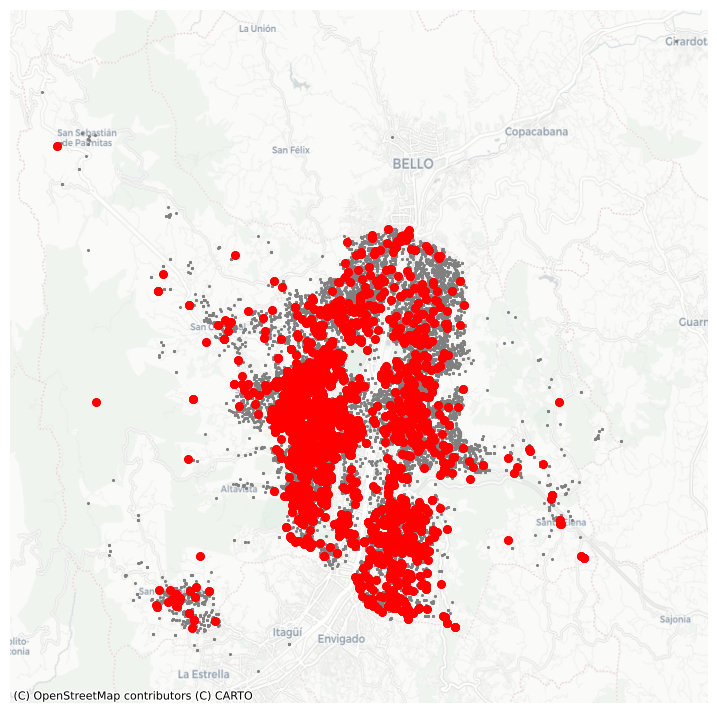

In [47]:
f, ax = plt.subplots(1, figsize=(9, 9))

# Subset points that are not part of any cluster (noise)
# Ahora esto funcionará porque db_viz tiene columnas "x" e "y"
noise = db_viz.loc[lbls == -1, ["x", "y"]]

# Plot noise in grey
ax.scatter(noise["x"], noise["y"], c="grey", s=5, linewidth=0)

# Plot all points that are not noise in red
# Usamos db_viz y la lógica de diferencia de índices
non_noise = db_viz.loc[db_viz.index.difference(noise.index)]

ax.scatter(
    non_noise["x"],
    non_noise["y"],
    c="red",
    linewidth=0,
)

# Add basemap
# Nota: Asegúrate de que tus coordenadas estén en Web Mercator (EPSG:3857)
# para que coincidan con el mapa base.
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)

# Remove axes
ax.set_axis_off()

# Display the figure
plt.show()